In [1]:
%run SPDEs.ipynb
%run Rule.ipynb
%run Noise.ipynb
%run Algorithm_1.ipynb
%run Model.ipynb

In [2]:
dx, dt = 0.01, 0.001 #space-time increments 
k = 1000 # Number of realizations
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

X, T = Noise().partition(a,b,dx), Noise().partition(s,t,dt) # space grid O_X and time grid O_T

W = Noise().WN_space_time_many(s, t, dt, a, b, dx, k) # Create realizations of space time white noise

\begin{align}
(\partial^2_t - \Delta) u &= cos(\pi\, u) + u^2 + u\cdot\xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
u(t,0) &= u(t,1)\quad\text{(Periodic BC)}\\
u(0,x) &= \sin(2\pi\,x)\\
\partial_t u(0,x) &= x(1-x).
\end{align}

In [3]:
ic = lambda x : np.sin(2*np.pi*x) # initial condition 
ic_t = lambda x : x*(1-x) # initial speed
mu = lambda x: np.cos(np.pi*x)+x**2 # drift
sigma = lambda x : x # diffusion

# solve wave equation
Wave_soln = SPDE(Type = 'W', BC = 'P', T = T, X = X, IC = ic, IC_t = ic_t, mu = mu, sigma = sigma).Wave(W)

100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


In [6]:
W0 = np.zeros(shape = (1, len(T), len(X))) # zero valued forcing

# Construct I_c[u_0]
I_c = SPDE(Type = 'W', BC = 'P', T = T, X = X, IC = ic).Wave(W0)
I_c = np.array([I_c[0] for _ in range(W.shape[0])])

# Construct I_s[v_0]
I_s = SPDE(Type = 'W', BC = 'P', T = T, X = X, IC_t = ic_t).Wave(W0)
I_s = np.array([I_s[0] for _ in range(W.shape[0])])

# solutions to the linearized equation
I_xi = SPDE(Type = 'W', BC = 'P', T = T, X = X).Wave(W)

# Will be used as an input to the model in order to speed up the model computation. All I_xi are solved in paralel

100%|██████████| 1000/1000 [00:02<00:00, 366.89it/s]


In [9]:
R = Rule(kernel_deg = 1.5, noise_deg = -1.5, free_num = 2) # initialize rule. additive width = 2
R.add_component(1, {'xi':1}) # multiplicative width = 1

deg = 1.5 # maximum degree
H = 4 # maximum height

I = SPDE(BC = 'P', T = T, X = X, Type = 'W').Integrate_Wave_trees # initialize integral operator I
M = Model(I, R, H, deg)

extra_planted = {'I_c[u_0]': I_c, "I_s[v_0]": I_s} # initialize \mathcal{J} and u^i functions

extra_deg = {'I_c[u_0]': 1, "I_s[v_0]": 1} 

key = {'I_c[u_0]', "I_s[v_0]"}

# Set time-space points at which functions of the model will be evaluated and stored in memory
points = {(-1,50)}

# create model
Features_for_points = M.create_model_points(W, dt = dt, lollipops = I_xi, extra_planted = extra_planted, extra_deg = extra_deg, key = key, points = points)


100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


In [14]:
trees = Features_for_points[(-1,50)].columns
no_speed = [a for a in trees if 'v' not in a]
no_initial = [a for a in no_speed if 'u' not in a]

 90%|████████▉ | 895/1000 [00:00<00:00, 4214.35it/s]

Creating labels dataset.


100%|██████████| 1000/1000 [00:00<00:00, 4459.65it/s]


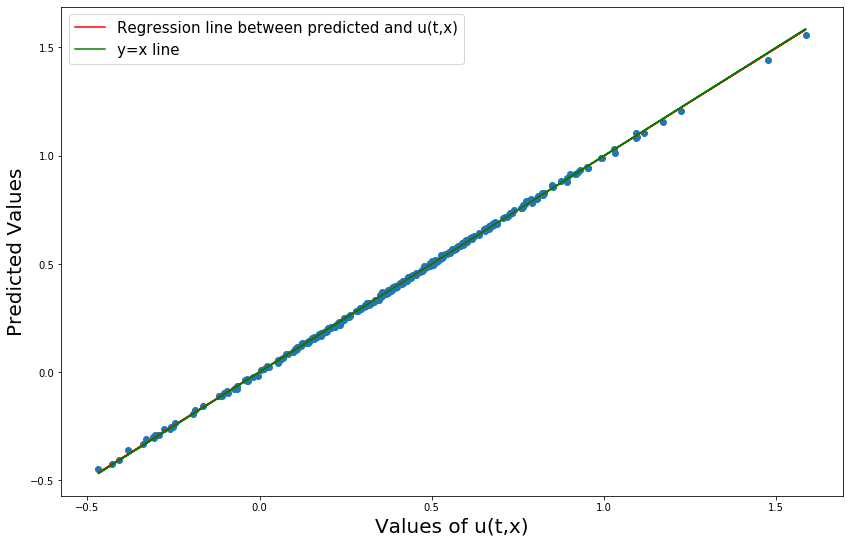

Error: 0.013301042557586875 . Tangent: 0.9964406202030369


In [21]:
# Prediction by algorithm 1 for the full model. 

t, x = -1, 50 # Point where prediction will be made
E = Experiment(t, x, t, x)
E.F = Features_for_points[(t,x)]
E.one_experiment(None, Wave, split = True)
E.show_regression_experiment()

100%|██████████| 1000/1000 [00:00<00:00, 6976.99it/s]

Creating labels dataset.


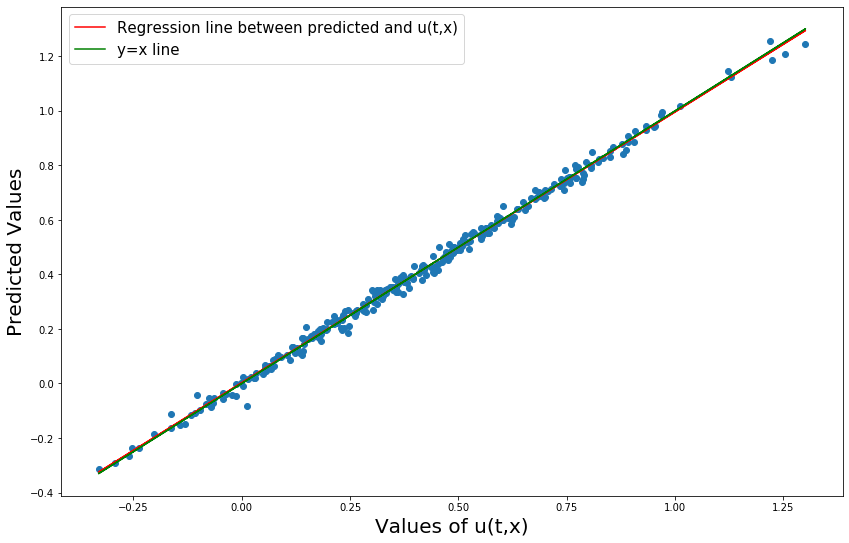

Error: 0.03903364610754997 . Tangent: 0.992937973875924


In [17]:
# Prediction by algorithm 1 for the model without initial speed. 

t, x = -1, 50 # Point where prediction will be made
E2 = Experiment(t, x, t, x)
E2.F = Features_for_points[(t,x)][no_speed]
E2.one_experiment(None, Wave, split = True)
E2.show_regression_experiment()

100%|██████████| 1000/1000 [00:00<00:00, 7312.98it/s]

Creating labels dataset.


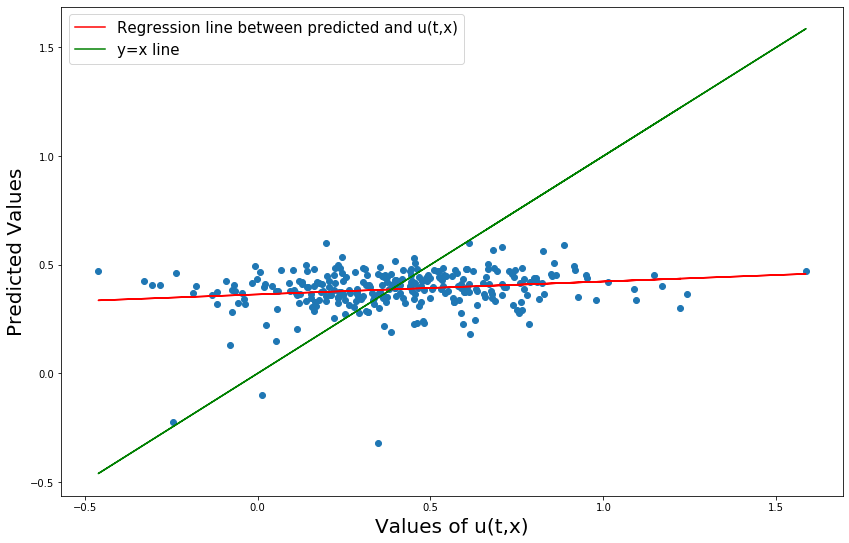

Error: 0.5835152954850676 . Tangent: 0.05945152286633583


In [18]:
# Prediction by algorithm 1 for the model without initial conditions. 

t, x = -1, 50 # Point where prediction will be made
E3 = Experiment(t, x, t, x)
E3.F = Features_for_points[(t,x)][no_initial]
E3.one_experiment(None, Wave, split = True)
E3.show_regression_experiment()

In [22]:
er, t = E.many_regression_experiments(1000)
er_no_speed, t_no_speed = E2.many_regression_experiments(1000)

100%|██████████| 1000/1000 [00:16<00:00, 59.13it/s]


In [23]:
print("Average Error for full model:", er)
print("Average Error for model without speed:", er_no_speed)

Average Error for full model: 0.013371529489132842
Average Error for model without speed: 0.04162038016966334
